# Categorizing Wine Quality with KNN and Decision Trees



In this notebook I practice **categorizing data as a human would** by using

two supervised classification methods:



- **k-Nearest Neighbors (KNN)**

- **Decision Trees**



I will:



- Turn the numeric wine `quality` score into **categories** (low / medium / high).

- Split the data into **80% training** and **20% testing**.

- Train and evaluate both KNN and a decision tree on the same split.

- Compare how well they classify wines using accuracy and confusion matrices.

In [46]:
# Imports and setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

sns.set(style="whitegrid", context="notebook")

## 1. Load the wine data

We reuse the red wine quality dataset so results are comparable to the
regression notebooks. Each row is a wine sample with several chemical
measurements and an expert `quality` score.

In [47]:
# Load white wine quality data
data_path = '../PCA/data/winequality-white.csv'
wine = pd.read_csv(data_path, sep=';')

wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


## 2. Turn numeric quality into categories

The original `quality` is an integer from 3 to 8. To treat this as a
**classification** problem, we group wines into three intuitive classes:

- **low** quality: scores ≤ 4
- **medium** quality: scores 5–6
- **high** quality: scores ≥ 7

This mimics how a human might label wines as low / medium / high rather than
using the exact numeric score.

In [48]:
# Create categorical quality labels
def quality_to_category(q):
    if q <= 5:
        return 'low'
    elif q <= 7:
        return 'medium'
    else:
        return 'high'

wine['quality_cat'] = wine['quality'].apply(quality_to_category)

wine['quality_cat'].value_counts().sort_index()

quality_cat
high       180
low       1640
medium    3078
Name: count, dtype: int64

## 3. Feature selection and 80/20 train–test split

We use the chemical measurements as predictor features `X` and the new
categorical label `quality_cat` as the target `y`. Then we split the data into:

- **80% training set**: used to fit the models.
- **20% test set**: held out until the end to evaluate how well the models
  generalize to new wines.

We also use `stratify=y` to keep class proportions similar in train and test.

In [49]:
# Use all numeric chemistry columns as features
feature_cols = [col for col in wine.columns if col not in ['quality', 'quality_cat']]
X = wine[feature_cols]
y = wine['quality_cat']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=67, stratify=y
)

X_train.shape, X_test.shape, y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)

((3918, 11),
 (980, 11),
 quality_cat
 medium    0.628382
 low       0.334865
 high      0.036753
 Name: proportion, dtype: float64,
 quality_cat
 medium    0.628571
 low       0.334694
 high      0.036735
 Name: proportion, dtype: float64)

## 4. Scale features for KNN

KNN uses distances between points, so it works better if all features are
on a similar scale. We standardize features (mean 0, std 1) **using only the
training set**, then apply the same transformation to the test set.

In [50]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled[:3]

array([[ 0.66388798,  0.014827  ,  0.53694543,  1.08204688, -0.64513867,
        -1.30981362, -1.09278568,  0.75119131, -1.18618902, -0.26393126,
         0.23438272],
       [-0.17125521,  0.014827  ,  0.0448972 ,  0.49481123,  0.1007293 ,
        -0.20329064, -0.64490672,  0.17524322,  0.40362449,  0.43383033,
         0.39648347],
       [ 0.1866633 , -0.57245701, -0.61116709,  0.5535348 , -0.87822242,
         0.08789962, -0.38560837, -0.57613733, -0.85497787, -1.31057364,
         1.61223904]])

## 5. Train and evaluate KNN classifier

We start with a simple KNN model using `k = 5` neighbors. We train it on the
scaled training data and evaluate it on the test data using:

- **Accuracy** on the test set.
- A **confusion matrix** to see which classes are confused.
- A short **classification report** (precision, recall, F1).

In [51]:
# Train KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

# Evaluate on test data
y_pred_knn = knn.predict(X_test_scaled)
knn_acc = accuracy_score(y_test, y_pred_knn)
cm_knn = confusion_matrix(y_test, y_pred_knn, labels=['low', 'medium', 'high'])

print(f"KNN test accuracy: {knn_acc:.3f}")
print("\nKNN classification report:\n", classification_report(y_test, y_pred_knn))
cm_knn

KNN test accuracy: 0.738

KNN classification report:
               precision    recall  f1-score   support

        high       0.24      0.11      0.15        36
         low       0.69      0.63      0.66       328
      medium       0.77      0.83      0.80       616

    accuracy                           0.74       980
   macro avg       0.57      0.52      0.54       980
weighted avg       0.72      0.74      0.73       980



array([[207, 119,   2],
       [ 93, 512,  11],
       [  1,  31,   4]])

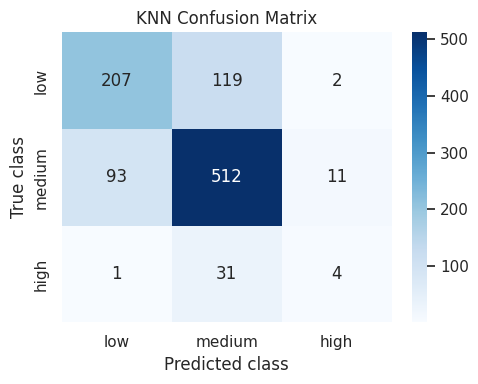

In [52]:
# Visualize KNN confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues',
            xticklabels=['low', 'medium', 'high'],
            yticklabels=['low', 'medium', 'high'])
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.title('KNN Confusion Matrix')
plt.tight_layout()
plt.show()

## 6. Train and evaluate Decision Tree classifier

Decision trees split the feature space into regions based on simple threshold
rules. They do not require feature scaling, so we use the **original**
training features `X_train` and evaluate on `X_test`. We again report
accuracy, a confusion matrix, and a classification report.

In [53]:
# Train Decision Tree classifier
tree = DecisionTreeClassifier(max_depth=4, random_state=67)
tree.fit(X_train, y_train)

# Evaluate on test data
y_pred_tree = tree.predict(X_test)
tree_acc = accuracy_score(y_test, y_pred_tree)
cm_tree = confusion_matrix(y_test, y_pred_tree, labels=['low', 'medium', 'high'])

print(f"Decision Tree test accuracy: {tree_acc:.3f}")
print("\nDecision Tree classification report:\n", classification_report(y_test, y_pred_tree))
cm_tree

Decision Tree test accuracy: 0.739

Decision Tree classification report:
               precision    recall  f1-score   support

        high       0.50      0.03      0.05        36
         low       0.66      0.68      0.67       328
      medium       0.78      0.81      0.80       616

    accuracy                           0.74       980
   macro avg       0.65      0.51      0.51       980
weighted avg       0.73      0.74      0.73       980



array([[222, 106,   0],
       [114, 501,   1],
       [  0,  35,   1]])

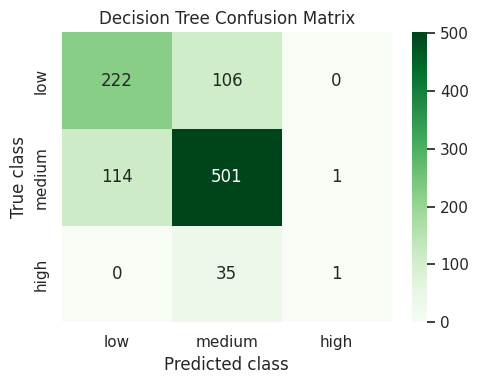

In [54]:
# Visualize Decision Tree confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm_tree, annot=True, fmt='d', cmap='Greens',
            xticklabels=['low', 'medium', 'high'],
            yticklabels=['low', 'medium', 'high'])
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.title('Decision Tree Confusion Matrix')
plt.tight_layout()
plt.show()

## 7. Comparing the models

Both models used the same **80/20 train test split**

Summarizing:

- `KNN tests` shows that Medium and Low have higher accuracy compared to high, I'd say this is because they got way more data than high property.
- `Decision Tree tests` show me that with the same limitations as the knn model this actually has better results in the high category with similar results in the other two. 


**Insight of results**

I think this gives us an insight on how both models work, KNN looks literally to the 5 closest wines because most nearby wines are low or medium, KNN almost always chooses low or medium, and almost never “high” and the decision tree learns and evaluates in a diferent way lets say it notices alcohol and sulphates being a good indicator of quality then it can still guess correctly even in rare cases like high.
